# The Curse of Dimensionality

Hi and welcome to my Knowvember talk!
This is based on my EDC talk from last year, together with some material from Matt and the book The Elements of Statistical Learning.
If you want to follow along, you can fetch this notebook from
## `kwinkunks/chrestomathy/felz/knowvember`

### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist
from scipy.special import gamma
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

Before we dive into the curse of dimensionality proper, let's first try to test our intuition about the behaviour of some reference shapes in high dimensions!

## Warmup: unit ball versus unit cube

### The unit cube

In [ ]:
def volume_of_cube(side_length: float, dimension: int) -> float:
    return side_length**dimension

In [ ]:
vols = [
    volume_of_cube(
        side_length=1,
        dimension=dim,
    )
    for dim in range(1, 26)
]

fig, ax = plt.subplots(figsize=(18, 8))

plt.plot(range(1, 26), vols, 'o-')
ax.grid(c='k', alpha=0.1)
plt.title("Volume of a unit cube of dimension N")
plt.xlabel("dimension N")
plt.ylabel("volume (arbitary units)")

plt.show()

In [ ]:
def length_of_cube_diagonal(side_length: float, dimension: int) -> float:
    far_diagonal = np.full(
        shape=(dimension,),
        fill_value=side_length,
    )
    return float(np.linalg.norm(far_diagonal))

In [ ]:
diags = [
    length_of_cube_diagonal(
        side_length=1,
        dimension=dim,
    )
    for dim in range(1, 26)
]

fig, ax = plt.subplots(figsize=(18, 8))

plt.plot(range(1, 26), diags, 'o-')
ax.grid(c='k', alpha=0.1)
plt.title("Maximal distance between two points in a unit cube of dimension N")
plt.xlabel("dimension N")
plt.ylabel("distance (arbitary units)")

plt.show()

### A brief 2-dimensional digression

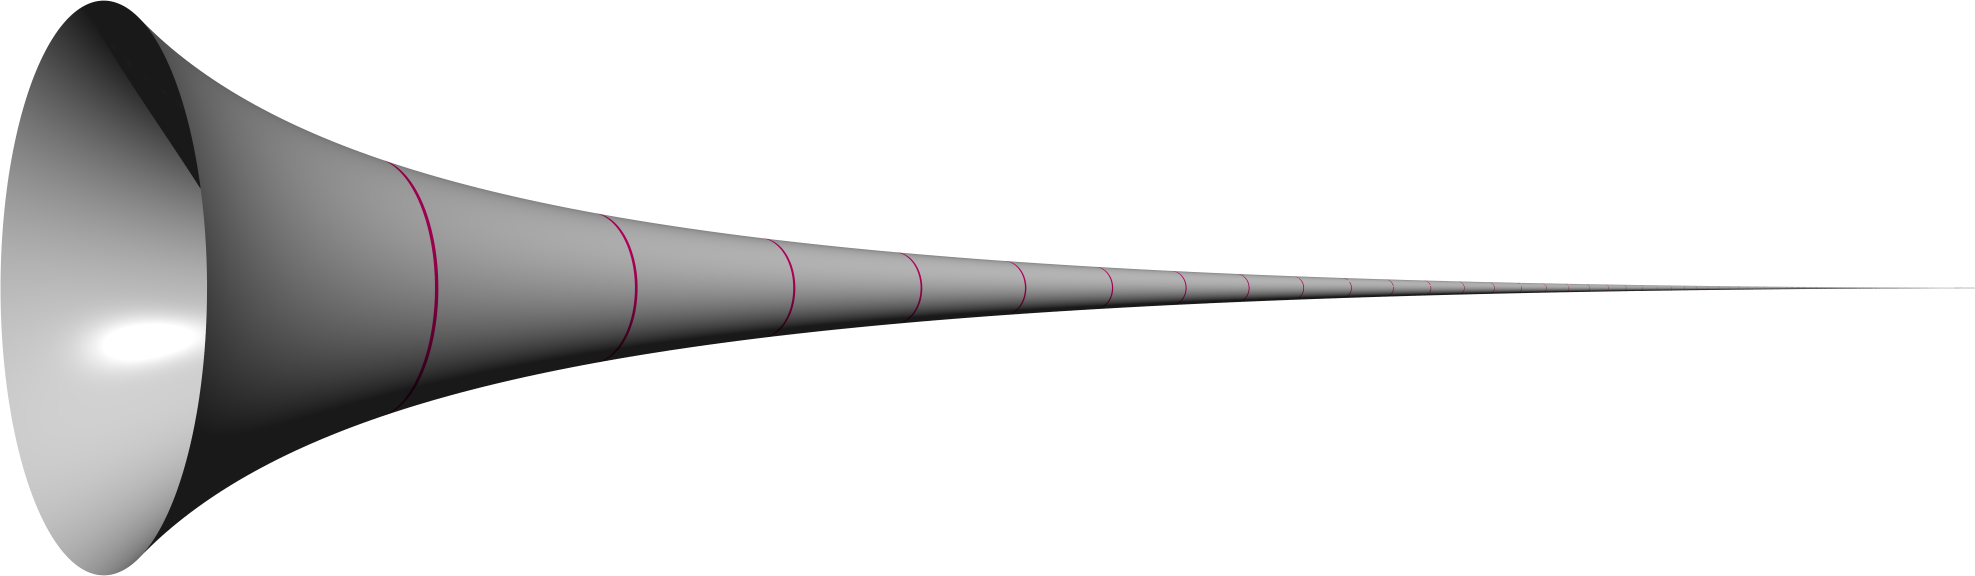

### The "unit" sphere

In [ ]:
def length_of_sphere_diagonal(radius: float, dimension: int) -> float:
    # can do a lot of complicated stuff here, or you can remember that the diameter is twice the radius
    return 2*radius  # note that this does NOT depend on the dimension!

In [ ]:
sphere_diags = [
    length_of_sphere_diagonal(
        radius=1/2,
        dimension=dim,
    )
    for dim in range(1, 26)
]

fig, ax = plt.subplots(figsize=(18, 8))

ax.grid(c='k', alpha=0.1)
plt.plot(range(1, 26), sphere_diags, 'o-')
plt.title("Maximal distance between two points in a \"unit\" sphere of dimension N")
plt.xlabel("dimension N")
plt.ylabel("distance (arbitary units)")

plt.show()

In [ ]:
def volume_of_sphere(radius: float, dimension: int) -> float:
    return radius**dimension * np.pi**(dimension/2) / gamma(dimension/2 + 1)

In [ ]:
sphere_vols = [
    volume_of_sphere(
        radius=1/2,
        dimension=dim,
    )
    for dim in range(1, 26)
]

fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(range(1, 26), sphere_vols, 'o-')
ax.grid(c='k', alpha=0.1)
plt.title("Volume of \"unit\" sphere of dimension N")
plt.xlabel("dimension N")
plt.ylabel("volume (arbitary units)")

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))

for r in [.5, .9, 1, 1.1, 1.15]:
    d = np.arange(1, 26)
    vols = [volume_of_sphere(radius=r, dimension=int(dim)) for dim in d]
    maxx = np.argmax(vols) + 1
    plt.plot(d, vols, 'o-', label=f'r = {r}')

ax.grid(c='k', alpha=0.1)
plt.legend()
plt.title("Volume of N-sphere of radius r")
plt.xlabel("dimension N")
plt.ylabel("volume (arbitary units)")

plt.show()

### Homeowork

#### What does this mean for others sequences of shapes with uniformly bounded distances?

## The Curse of Dimensionality by example: classification with KNN

### Examples of High-dimensional Data

### The K-Nearest Neighbours (KNN) algorithm

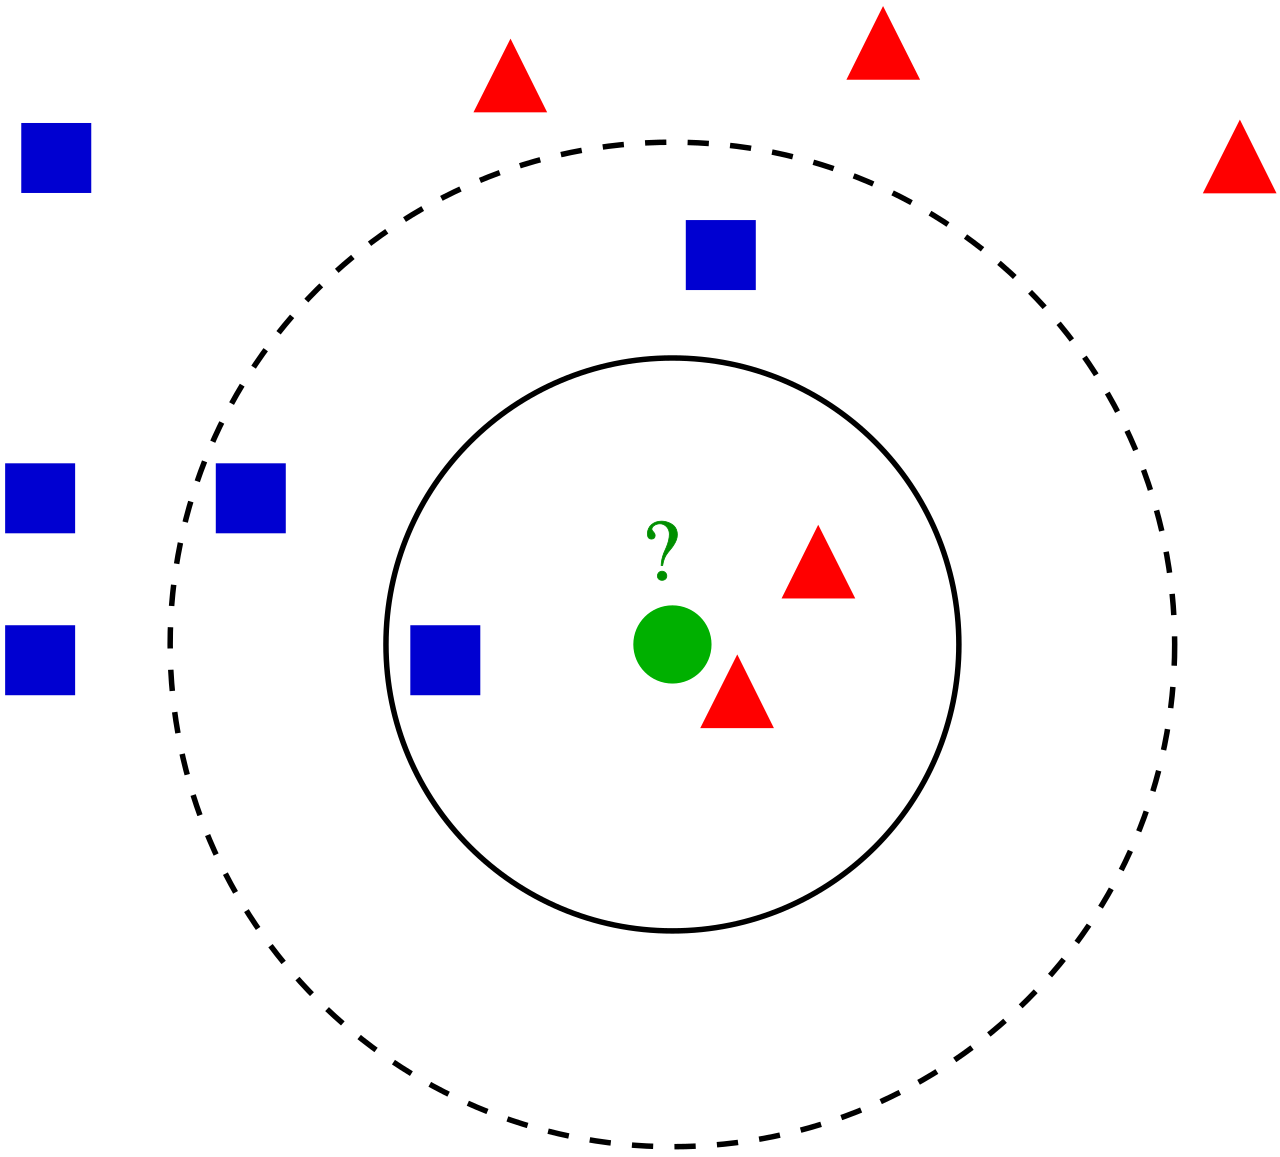
By Antti Ajanki AnAj - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=2170282

In [ ]:
N_SAMPLES = 1_000

N_FEATURES = 750

N_INFORMATIVE = 10

N_REDUNDANT = 0

N_CLASSES = 7

SHUFFLE = True


X, y = make_classification(n_samples=N_SAMPLES, n_features=N_FEATURES, n_informative=N_INFORMATIVE, n_redundant=N_REDUNDANT, n_classes=N_CLASSES, random_state=42, shuffle=SHUFFLE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

acc_scores = []
for N in range(1, N_FEATURES + 1):
    neigh = KNeighborsClassifier(n_neighbors=16)
    
    neigh.fit(X_train[:,:N], y_train)
    
    y_pred = neigh.predict(X_test[:,:N])
    
    acc_scores.append(accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(18, 8))

plt.plot(acc_scores)
ax.grid(c='k', alpha=0.1)
ax.hlines(y=1/7, xmin=0, xmax=N_FEATURES + 1, colors='r')
plt.title("KNN Classifier with K=16 Performance")
plt.ylabel("Accuracy")
plt.xlabel("Number of features used")

plt.show()

#### Some simple counting: you need to know a lot

#### "Concentration of measure": it's difficult to sample well (and the demise of distance)

In [ ]:
def sample_dists_between_points_in_unit_cube(dimension: int, n_samples: int):
    X = np.random.random(size=(n_samples, dimension))
    return pdist(X)

In [ ]:
dims = [2, 20, 200, 2000]

fig, axs = plt.subplots(ncols=len(dims), figsize=(18, 8), sharey=True)

for dim, ax in zip(dims, axs):
    d = sample_dists_between_points_in_unit_cube(dimension=dim, n_samples=200)
    ax.hist(d)
    ax.set_xlim(0, 20)
    ax.set_title(f'{dim}-D')
    ax.set_xlabel("distance (arbitrary units)")
    ax.grid(c='k', alpha=0.1)

plt.show()

In [ ]:
mean_distance = []
mean_std = []
max_observed = []
min_observed = []

for dim in range(1,2_000):
    d = sample_dists_between_points_in_unit_cube(dimension=dim, n_samples=200)
    mean_distance.append(np.mean(d))
    mean_std.append(np.std(d))
    max_observed.append(np.max(d))
    min_observed.append(np.min(d))

plt.figure(figsize=(18,8))

plt.plot(range(1, 2_000),
    [
        length_of_cube_diagonal(
            side_length=1,
            dimension=dim,
        )
        for dim in range(1, 2_000)
    ],
    label='max_possible'
)
plt.plot(range(1, 2_000), mean_distance, label='mean_observed')
plt.plot(range(1, 2_000), max_observed, label='max_observed')
plt.plot(range(1, 2_000), min_observed, label='min_observed')
plt.plot(range(1, 2_000), [0]*1_999, label='min_possible')
plt.title("Sampled distances between random points in a unit cube of dimension N")
plt.xlabel("dimension N")
plt.ylabel("distance (arbitary units)")
plt.legend()

plt.show()

## What could you do about this?

### Reduce dimensions as best you can

#### Feature engineering / domain knowledge

#### Dimension reduction algorithms

In [ ]:
N_SAMPLES = 10_000

N_FEATURES = 750

N_INFORMATIVE = 10

N_REDUNDANT = 0

N_CLASSES = 7

SHUFFLE = False


X, y = make_classification(n_samples=N_SAMPLES, n_features=N_FEATURES, n_informative=N_INFORMATIVE, n_redundant=N_REDUNDANT, n_classes=N_CLASSES, random_state=42, shuffle=SHUFFLE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = make_pipeline(
    PCA(n_components=11),
    KNeighborsClassifier(n_neighbors=16),
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

### Make appropriate modelling assumptions (out of scope for this talk)

## What about regression?

### Where is the volume?

For the cube:

For the sphere:

In [ ]:
def sphere_volume_fraction_in_shell(dimension: int, s: float) -> float:
    return (volume_of_sphere(dimension=dimension, radius=1/2) - volume_of_sphere(dimension=dimension, radius=(1/2 - s))) / volume_of_sphere(dimension=dimension, radius=1/2)

In [ ]:
fracs = [
    sphere_volume_fraction_in_shell(
        s=0.01,
        dimension=dim,
    )
    for dim in range(1, 200)
]

fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(range(1, 200), fracs, 'o-')
ax.grid(c='k', alpha=0.1)
plt.title("Fraction of volume in \"unit\" sphere of dimension N that is within 0.01 of the surface")
plt.xlabel("dimension N")
plt.ylabel("volume ratio")

plt.show()

### Bet on sparsity

## Caveat for this talk

I'm assuming that the generating processes are (close to) uniform, which is usually not the case (*The Blessing of Non-uniformity*).

It is quite common for data to cluster around lower-dimensional manifolds (whatever those are)
